In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install keras==2.4.3
# !pip install tensorflow==2.4.1

In [4]:
!pip install keras-multi-head
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# For Weights and Biases
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
import wandb
from wandb.keras import WandbCallback

# Login to W&B
wandb.login()

In [8]:
%cd /content/drive/MyDrive/Colab_Notebooks/FINAL_THESIS_PROJECT/codes

/content/drive/.shortcut-targets-by-id/1-TsISowGVH-c2pg1SMS88BRnBWd9B3c0/FINAL_THESIS_PROJECT/codes


In [9]:
from features import *
from helper import *

In [10]:
code_path = "/content/drive/MyDrive/Colab_Notebooks/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [11]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [11]:
mocap_rot = []

for ses_mod in data2:
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))  
    x_rot[np.isnan(x_rot)]=0
    mocap_rot.append( x_rot )
    
mocap_rot = np.array(mocap_rot)
mocap_rot = mocap_rot.reshape(-1,200,165,1)
mocap_rot.shape
# print(type(mocap_rot))

(4936, 200, 165, 1)

In [12]:
# Y=[]
# for ses_mod in data2:
#     Y.append(ses_mod['emotion'])
    
# # Y = label_binarize(Y,emotions_used)
# Y = np.array(Y)
# print(type(Y))
# Y[0],Y[1], Y[2]

Y=[]
for ses_mod in data2:
  if ses_mod['emotion'] == 'neu':
    Y.append(0)
  elif ses_mod['emotion'] == 'ang':
    Y.append(1)
  elif ses_mod['emotion'] == 'exc':
    Y.append(2)
  elif ses_mod['emotion'] == 'sad':
    Y.append(3)

Y = np.array(Y)
print(type(Y))
Y[0],Y[1], Y[2]

<class 'numpy.ndarray'>


(0, 0, 0)

In [13]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [14]:
xtrain_mocap_rot = mocap_rot[:3838]
xtest_mocap_rot = mocap_rot[3838:]
ytrain_mocap_rot = Y[:3838]
ytest_mocap_rot = Y[3838:]

print(xtrain_mocap_rot.shape)
print(xtest_mocap_rot.shape)

print(ytrain_mocap_rot.shape)
print(ytest_mocap_rot.shape)

(3838, 200, 165, 1)
(1098, 200, 165, 1)
(3838,)
(1098,)


#**Model_Head 1A**

In [ ]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention

def create_model_1():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)
    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [ ]:
model = create_model_1()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 165, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 82, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 82, 128)      295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 41, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 41, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 41, 128)       147584

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=300, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/300
39/39 [==============================] - 36s 806ms/step - loss: 1.8577 - acc: 0.3015 - val_loss: 1.3398 - val_acc: 0.3024
Epoch 2/300
39/39 [==============================] - 26s 657ms/step - loss: 1.2814 - acc: 0.3880 - val_loss: 1.3158 - val_acc: 0.3953
Epoch 3/300
39/39 [==============================] - 26s 669ms/step - loss: 1.2245 - acc: 0.4468 - val_loss: 1.3310 - val_acc: 0.4126
Epoch 4/300
39/39 [==============================] - 27s 699ms/step - loss: 1.1786 - acc: 0.4581 - val_loss: 1.6107 - val_acc: 0.3324
Epoch 5/300
39/39 [==============================] - 27s 682ms/step - loss: 1.1396 - acc: 0.4937 - val_loss: 1.3341 - val_acc: 0.3998
Epoch 6/300
39/39 [==============================] - 26s 678ms/step - loss: 1.1119 - acc: 0.5156 - val_loss: 1.6090 - val_acc: 0.3607
Epoch 7/300
39/39 [==============================] - 27s 686ms/step - loss: 1.0816 - acc: 0.5302 - val_loss: 1.6272 - val_acc: 0.3461
Epoch 8/300
39/39 [==============================] - 27s 685ms

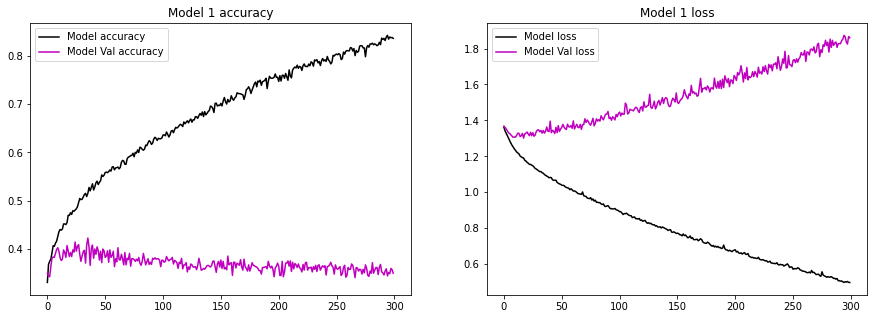

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.48922 dan Training Accuracy 84.47%
Validation Loss 1.85959 dan Validation Accuracy 34.97%


# **Model_Head 1B**

In [ ]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_2():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [ ]:
model = create_model_2()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 165, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 82, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 82, 256)      590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 41, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 41, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 41, 128)       147584

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=100, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/100
39/39 [==============================] - 77s 1s/step - loss: 1.3967 - acc: 0.2549 - val_loss: 1.3865 - val_acc: 0.3488
Epoch 2/100
39/39 [==============================] - 45s 1s/step - loss: 1.3680 - acc: 0.3384 - val_loss: 1.3830 - val_acc: 0.3497
Epoch 3/100
39/39 [==============================] - 44s 1s/step - loss: 1.3623 - acc: 0.3464 - val_loss: 1.3842 - val_acc: 0.3515
Epoch 4/100
39/39 [==============================] - 44s 1s/step - loss: 1.3617 - acc: 0.3429 - val_loss: 1.3823 - val_acc: 0.3497
Epoch 5/100
39/39 [==============================] - 44s 1s/step - loss: 1.3601 - acc: 0.3484 - val_loss: 1.3777 - val_acc: 0.3497
Epoch 6/100
39/39 [==============================] - 44s 1s/step - loss: 1.3552 - acc: 0.3455 - val_loss: 1.3752 - val_acc: 0.3497
Epoch 7/100
39/39 [==============================] - 44s 1s/step - loss: 1.3519 - acc: 0.3471 - val_loss: 1.3658 - val_acc: 0.3497
Epoch 8/100
39/39 [==============================] - 44s 1s/step - loss: 1.3460 - a

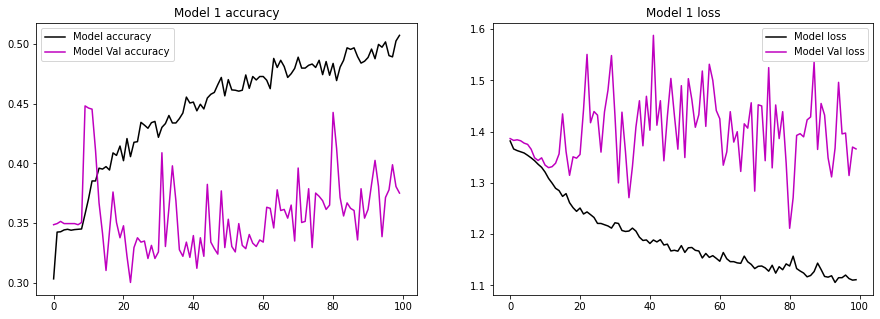

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.09788 dan Training Accuracy 51.41%
Validation Loss 1.36634 dan Validation Accuracy 37.52%


# **Model_Head 1C**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_3():
    img_inputs = keras.Input(shape=(200, 165, 1))
    conv_1 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu')(conv_4)

    # x = Reshape((-1, 32))(conv_3)
    
    # #LSTM
    # x = LSTM(32, return_sequences=True)(x)
    # x = SeqSelfAttention(attention_activation ='tanh')(x)
    # x = LSTM(32, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_3()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 165, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 165, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 82, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 82, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 41, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 41, 32)        36896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 41, 64)        18496 

In [17]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [18]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=100, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/100
39/39 [==============================] - 27s 456ms/step - loss: 1.6612 - acc: 0.3030 - val_loss: 1.3023 - val_acc: 0.3998
Epoch 2/100
39/39 [==============================] - 12s 313ms/step - loss: 1.3205 - acc: 0.3642 - val_loss: 1.3045 - val_acc: 0.3625
Epoch 3/100
39/39 [==============================] - 12s 314ms/step - loss: 1.2493 - acc: 0.4303 - val_loss: 1.3019 - val_acc: 0.3962
Epoch 4/100
39/39 [==============================] - 12s 313ms/step - loss: 1.2187 - acc: 0.4372 - val_loss: 1.2870 - val_acc: 0.3752
Epoch 5/100
39/39 [==============================] - 12s 312ms/step - loss: 1.2151 - acc: 0.4348 - val_loss: 1.5306 - val_acc: 0.3370
Epoch 6/100
39/39 [==============================] - 12s 313ms/step - loss: 1.1861 - acc: 0.4637 - val_loss: 1.3920 - val_acc: 0.3588
Epoch 7/100
39/39 [==============================] - 12s 317ms/step - loss: 1.1519 - acc: 0.4691 - val_loss: 1.3855 - val_acc: 0.3725
Epoch 8/100
39/39 [==============================] - 13s 322ms

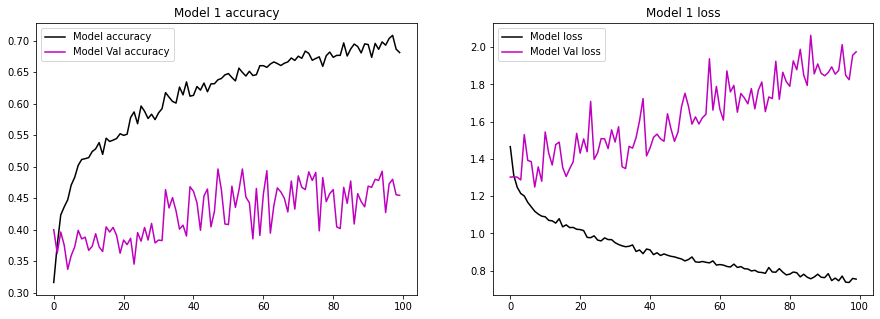

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [20]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [21]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.71828 dan Training Accuracy 71.60%
Validation Loss 1.97507 dan Validation Accuracy 45.45%


#**Model_rot 1**

In [ ]:
def gru_model_rot1(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot1()
model.summary()

hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=5, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200, 1024)         3658752   
                                                                 
 gru_1 (GRU)                 (None, 200, 512)          2362368   
                                                                 
 gru_2 (GRU)                 (None, 256)               591360    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
 activation_1 (Activation)   (None, 4)                 0

ValueError: ignored

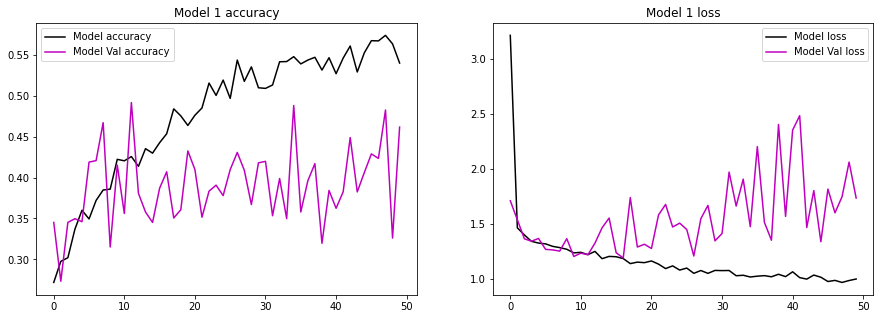

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.96962 dan Training Accuracy 58.21%
Validation Loss 1.73647 dan Validation Accuracy 46.17%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.79      0.30      0.43       933
         exc       0.74      0.64      0.69       742
         neu       0.58      0.45      0.51      1324
         sad       0.65      0.31      0.42       839

   micro avg       0.66      0.42      0.51      3838
   macro avg       0.69      0.42      0.51      3838
weighted avg       0.68      0.42      0.50      3838
 samples avg       0.42      0.42      0.42      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.40      0.01      0.02       170
         exc       0.48      0.85      0.62       299
         neu       0.55      0.41      0.47       384
         sad       0.00      0.00      0.00       245

   micro avg       0.51      0.38      0.43      1098
   macro avg       0.36      0.32      0.28      1098
weighted avg       0.39      0.38      0.33      1098
 samples avg       0.38      0.38      0.38      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


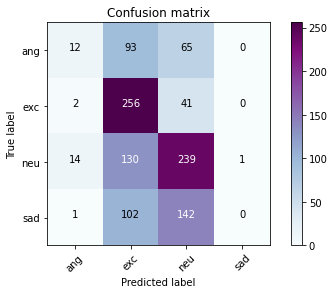

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 2**

In [ ]:
def gru_model_rot2(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot2()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 200, 1024)         3658752   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
gru_7 (GRU)                  (None, None, 512)         2362368   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
gru_8 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)              

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 45s 1s/step - loss: 4.1015 - accuracy: 0.2697 - val_loss: 1.4087 - val_accuracy: 0.2049
Epoch 2/50
39/39 [==============================] - 42s 1s/step - loss: 1.4101 - accuracy: 0.2974 - val_loss: 1.4489 - val_accuracy: 0.1949
Epoch 3/50
39/39 [==============================] - 43s 1s/step - loss: 1.3854 - accuracy: 0.3246 - val_loss: 1.3185 - val_accuracy: 0.3852
Epoch 4/50
39/39 [==============================] - 43s 1s/step - loss: 1.3837 - accuracy: 0.3154 - val_loss: 1.3640 - val_accuracy: 0.3288
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 1.3417 - accuracy: 0.3351 - val_loss: 1.3040 - val_accuracy: 0.4763
Epoch 6/50
39/39 [==============================] - 42s 1s/step - loss: 1.3223 - accuracy: 0.3832 - val_loss: 1.2446 - val_accuracy: 0.4845
Epoch 7/50
39/39 [==============================] - 42s 1s/step - loss: 1.3354 - accuracy: 0.3554 - val_loss: 1.2252 - val_accuracy: 0.4973
Epoch 8/50
39/39 [==

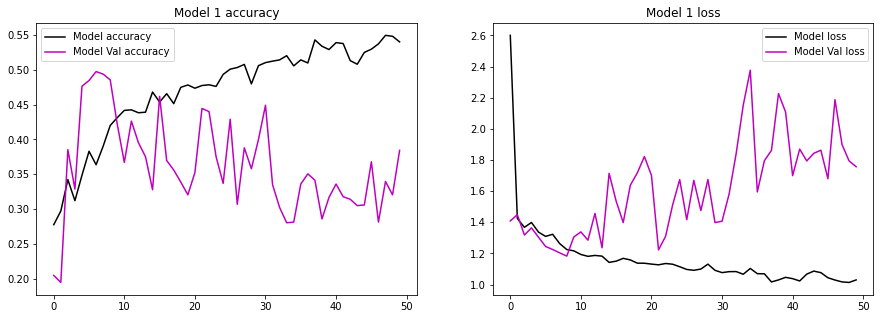

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.01332 dan Training Accuracy 55.60%
Validation Loss 1.75683 dan Validation Accuracy 38.43%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.71      0.35      0.47       933
         exc       0.77      0.55      0.64       742
         neu       0.57      0.31      0.40      1324
         sad       0.82      0.08      0.15       839

   micro avg       0.68      0.32      0.43      3838
   macro avg       0.72      0.32      0.41      3838
weighted avg       0.70      0.32      0.41      3838
 samples avg       0.32      0.32      0.32      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.08      0.12       170
         exc       0.47      0.85      0.60       299
         neu       0.59      0.15      0.24       384
         sad       0.00      0.00      0.00       245

   micro avg       0.47      0.30      0.36      1098
   macro avg       0.32      0.27      0.24      1098
weighted avg       0.37      0.30      0.27      1098
 samples avg       0.30      0.30      0.30      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


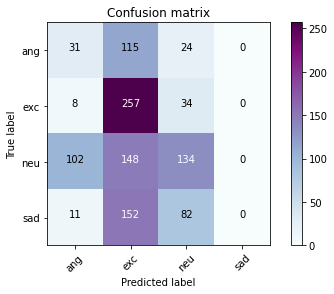

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 3**

In [ ]:
def gru_model_rot3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot3()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 86s 2s/step - loss: 5.6839 - accuracy: 0.2688 - val_loss: 1.3755 - val_accuracy: 0.2741
Epoch 2/50
39/39 [==============================] - 79s 2s/step - loss: 1.4262 - accuracy: 0.3104 - val_loss: 1.3692 - val_accuracy: 0.3470
Epoch 3/50
39/39 [==============================] - 79s 2s/step - loss: 1.3609 - accuracy: 0.3381 - val_loss: 1.2898 - val_accuracy: 0.3889
Epoch 4/50
39/39 [==============================] - 78s 2s/step - loss: 1.3134 - accuracy: 0.3528 - val_loss: 1.3140 - val_accuracy: 0.3069
Epoch 5/50
39/39 [==============================] - 79s 2s/step - loss: 1.2905 - accuracy: 0.3747 - val_loss: 1.2760 - val_accuracy: 0.3953
Epoch 6/50
39/39 [==============================] - 80s 2s/step - loss: 1.3019 - accuracy: 0.3752 - val_loss: 1.3711 - val_accuracy: 0.4089
Epoch 7/50
39/39 [==============================] - 77s 2s/step - loss: 1.2786 - accuracy: 0.3840 - val_loss: 1.2191 - val_accuracy: 0.4608
Epoch 8/50
39/39 [==

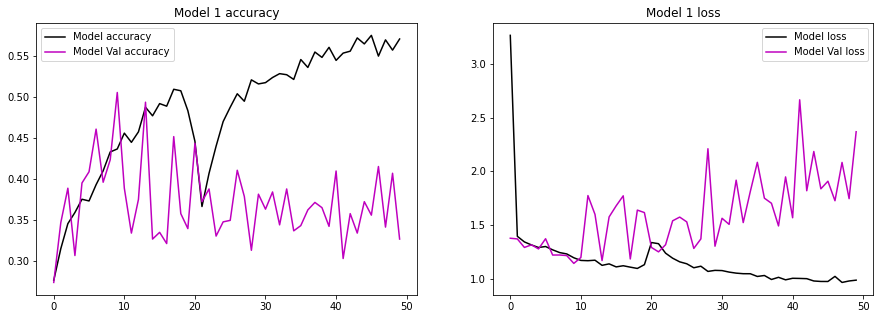

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.03573 dan Training Accuracy 54.04%
Validation Loss 2.36783 dan Validation Accuracy 32.70%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.28      0.41       933
         exc       0.62      0.76      0.68       742
         neu       0.61      0.28      0.39      1324
         sad       0.82      0.11      0.20       839

   micro avg       0.66      0.34      0.44      3838
   macro avg       0.70      0.36      0.42      3838
weighted avg       0.69      0.34      0.41      3838
 samples avg       0.34      0.34      0.34      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.07      0.01      0.01       170
         exc       0.36      0.91      0.51       299
         neu       0.70      0.08      0.15       384
         sad       0.00      0.00      0.00       245

   micro avg       0.37      0.28      0.32      1098
   macro avg       0.28      0.25      0.17      1098
weighted avg       0.35      0.28      0.19      1098
 samples avg       0.28      0.28      0.28      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


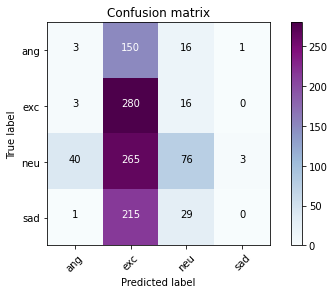

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 4**

In [ ]:
def gru_model_rot4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot4()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 1024)        65601     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1969152   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 91s 2s/step - loss: 7.3724 - accuracy: 0.2682 - val_loss: 1.4473 - val_accuracy: 0.3424
Epoch 2/50
39/39 [==============================] - 82s 2s/step - loss: 1.4471 - accuracy: 0.3262 - val_loss: 1.3984 - val_accuracy: 0.3497
Epoch 3/50
39/39 [==============================] - 84s 2s/step - loss: 1.3983 - accuracy: 0.3183 - val_loss: 1.3288 - val_accuracy: 0.2860
Epoch 4/50
39/39 [==============================] - 83s 2s/step - loss: 1.3392 - accuracy: 0.3478 - val_loss: 1.2851 - val_accuracy: 0.4599
Epoch 5/50
39/39 [==============================] - 85s 2s/step - loss: 1.2991 - accuracy: 0.3804 - val_loss: 1.2230 - val_accuracy: 0.4872
Epoch 6/50
39/39 [==============================] - 84s 2s/step - loss: 1.2831 - accuracy: 0.3880 - val_loss: 1.2359 - val_accuracy: 0.4772
Epoch 7/50
39/39 [==============================] - 84s 2s/step - loss: 1.2307 - accuracy: 0.4132 - val_loss: 1.2290 - val_accuracy: 0.4053
Epoch 8/50
39/39 [==

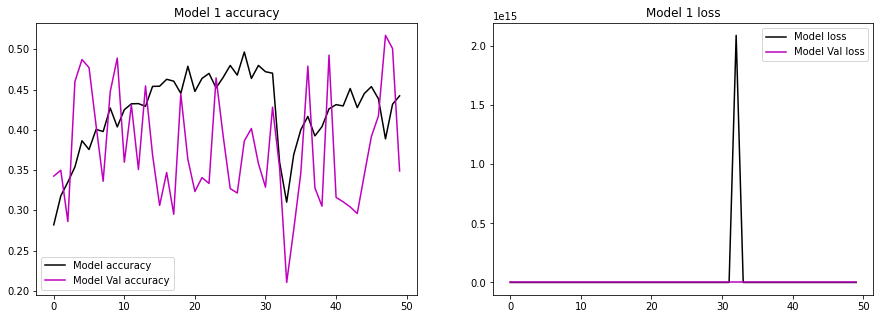

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.14516 dan Training Accuracy 45.10%
Validation Loss 1.51959 dan Validation Accuracy 34.88%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.62      0.13      0.21       933
         exc       0.82      0.42      0.55       742
         neu       0.56      0.02      0.03      1324
         sad       0.81      0.02      0.03       839

   micro avg       0.75      0.12      0.21      3838
   macro avg       0.71      0.14      0.21      3838
weighted avg       0.68      0.12      0.18      3838
 samples avg       0.12      0.12      0.12      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.23      0.10      0.14       170
         exc       0.57      0.79      0.66       299
         neu       0.57      0.02      0.04       384
         sad       0.00      0.00      0.00       245

   micro avg       0.52      0.24      0.33      1098
   macro avg       0.34      0.23      0.21      1098
weighted avg       0.39      0.24      0.22      1098
 samples avg       0.24      0.24      0.24      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


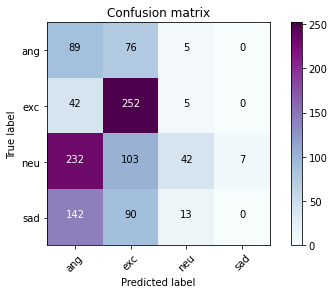

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MOCAP_COMBINED**

In [12]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append( x_mocap )
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

(4936, 200, 189, 1)

In [13]:
Y=[]
for ses_mod in data2:
  if ses_mod['emotion'] == 'neu':
    Y.append(0)
  elif ses_mod['emotion'] == 'ang':
    Y.append(1)
  elif ses_mod['emotion'] == 'exc':
    Y.append(2)
  elif ses_mod['emotion'] == 'sad':
    Y.append(3)


# Solving the none(1) and none(4) incompatibilty 
# Sparse takes integers as ys. Categorical takes ohe as ys. 
# In here, we map emotions to integers and later use Sparse_Categorrical ...

# emolst = ['neu','ang','exc','sad']
# emodict = dict([(b, a+b) for a, b in enumerate(sorted(set(emolst)))])
# Y = [emodict[i] for i in emolst]

# emodict = {'neu': 0, 
#            'ang': 1, 
#            'exc': 2,
#            'sad': 3,}

# emolst = [] # ['neu', 'sad'] 
# Y = [emodict[i] for i in emolst]

# print(Y)
# assert False

Y = np.array(Y)
    
# Y = label_binarize(Y,emotions_used)

print(type(Y))

Y[0]

<class 'numpy.ndarray'>


0

In [14]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [15]:
xtrain_mocap_combined = x_train_mocap[:3838]
xtest_mocap_combined = x_train_mocap[3838:]
ytrain_mocap_combined = Y[:3838]
ytest_mocap_combined = Y[3838:]

print(xtrain_mocap_combined.shape)
print(xtest_mocap_combined.shape)
print(type(xtrain_mocap_combined))
print(type(xtest_mocap_combined))

print(ytrain_mocap_combined.shape)
print(ytest_mocap_combined.shape)
print(type(ytrain_mocap_combined))
print(type(ytest_mocap_combined))

(3838, 200, 189, 1)
(1098, 200, 189, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3838,)
(1098,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# ytrain_mocap_combined = list(map(str, ytrain_mocap_combined))
# ytest_mocap_combined = list(map(str, ytest_mocap_combined))
# print(ytrain_mocap_combined)
# print(ytest_mocap_combined)

['neu', 'neu', 'neu', 'neu', 'ang', 'neu', 'ang', 'ang', 'sad', 'sad', 'sad', 'neu', 'sad', 'sad', 'neu', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'neu', 'sad', 'neu', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'sad', 'neu', 'sad', 'sad', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'exc', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'ang', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu'

In [ ]:
# ytrain_mocap_combined = np.array(ytrain_mocap_combined)
# ytest_mocap_combined = np.array(ytest_mocap_combined)x

#**Model_Combined 1A**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention

def create_model_1():
    img_inputs = keras.Input(shape=(200, 189, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)
    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_1()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 189, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 189, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 94, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 94, 128)      295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 47, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 47, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 47, 128)       147584

In [20]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='wav2vec_Mocap_com1A', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 1e-5,
                         "epochs": 100,
                         "batch_size": 100,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "2D-CNN",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

GFLOPS,3.94864


In [22]:
optimizer=keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer, config.loss_fn, 
              config.metrics)

In [23]:
hist = model.fit(xtrain_mocap_combined, ytrain_mocap_combined, 
                 batch_size=config.batch_size, epochs=config.epochs, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_combined, ytest_mocap_combined), callbacks=[WandbCallback()])

# validation_data=(xtest_mocap_combined, ytest_mocap_combined)

Epoch 1/100
39/39 [==============================] - 43s 933ms/step - loss: 3.2567 - acc: 0.2735 - val_loss: 1.4834 - val_acc: 0.1758
Epoch 2/100
39/39 [==============================] - 29s 739ms/step - loss: 1.3388 - acc: 0.3349 - val_loss: 1.3659 - val_acc: 0.3279
Epoch 3/100
39/39 [==============================] - 29s 739ms/step - loss: 1.2666 - acc: 0.4240 - val_loss: 1.3232 - val_acc: 0.3816
Epoch 4/100
39/39 [==============================] - 29s 746ms/step - loss: 1.2164 - acc: 0.4701 - val_loss: 1.2995 - val_acc: 0.3716
Epoch 5/100
39/39 [==============================] - 29s 743ms/step - loss: 1.1884 - acc: 0.4773 - val_loss: 1.3108 - val_acc: 0.3597
Epoch 6/100
39/39 [==============================] - 29s 741ms/step - loss: 1.1607 - acc: 0.4901 - val_loss: 1.2935 - val_acc: 0.4326
Epoch 7/100
39/39 [==============================] - 29s 741ms/step - loss: 1.1407 - acc: 0.4987 - val_loss: 1.4016 - val_acc: 0.3397
Epoch 8/100
39/39 [==============================] - 29s 744ms

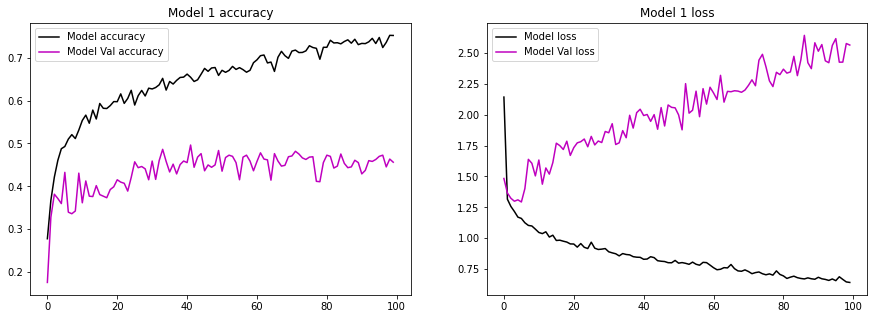

In [24]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [25]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [26]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.62569 and Training Accuracy 76.52%
Validation Loss 2.56293 and Validation Accuracy 45.63%


In [67]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")

pred = np.argmax(model.predict(xtrain_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(pred, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       1.00      1.00      1.00      1441
         exc       0.44      1.00      0.61      1061
         neu       0.00      0.00      0.00       569
         sad       0.00      0.00      0.00       767

    accuracy                           0.65      3838
   macro avg       0.36      0.50      0.40      3838
weighted avg       0.50      0.65      0.55      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
# CR untuk Validation Data
print("model 1")
pred = np.argmax(model.predict(xtest_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.42      0.66      0.52       384
         exc       0.22      0.62      0.32       170
         neu       0.00      0.00      0.00       299
         sad       0.00      0.00      0.00       245

    accuracy                           0.33      1098
   macro avg       0.16      0.32      0.21      1098
weighted avg       0.18      0.33      0.23      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.66 0.26 0.07 0.  ]
 [0.38 0.5  0.12 0.  ]
 [0.41 0.05 0.54 0.  ]
 [0.67 0.22 0.11 0.  ]]


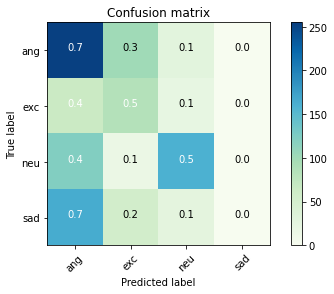

In [158]:
import itertools
y_pred = np.argmax(model.predict(xtest_mocap_combined), axis=1)
y_pred_classes = np.argmax(Y_pred) 
# y_true = np.argmax(ytest_mocap_combined,axis=1) 

from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(ytest_mocap_combined, y_pred)
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 



# **Model_Head 1B**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_2():
    img_inputs = keras.Input(shape=(200, 189, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_2()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 189, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 189, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 94, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 94, 256)      590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 47, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 47, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 47, 128)       147584

In [17]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='wav2vec_Mocap_com1B', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 1e-5,
                         "epochs": 100,
                         "batch_size": 100,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "2D-CNN_LSTM",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

In [20]:
optimizer=keras.optimizers.RMSprop(config.learning_rate)
model.compile(optimizer, config.loss_fn, 
              config.metrics)

In [21]:
hist = model.fit(xtrain_mocap_combined, ytrain_mocap_combined, 
                 batch_size=config.batch_size, epochs=config.epochs, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_combined, ytest_mocap_combined), callbacks=[WandbCallback()])

# validation_data=(xtest_mocap_combined, ytest_mocap_combined)

Epoch 1/100
39/39 [==============================] - 61s 1s/step - loss: 1.3736 - acc: 0.3150 - val_loss: 1.3847 - val_acc: 0.3470
Epoch 2/100
39/39 [==============================] - 58s 1s/step - loss: 1.3615 - acc: 0.3444 - val_loss: 1.3872 - val_acc: 0.3488
Epoch 3/100
39/39 [==============================] - 58s 1s/step - loss: 1.3545 - acc: 0.3579 - val_loss: 1.3798 - val_acc: 0.3488
Epoch 4/100
39/39 [==============================] - 58s 1s/step - loss: 1.3560 - acc: 0.3487 - val_loss: 1.3864 - val_acc: 0.3488
Epoch 5/100
39/39 [==============================] - 58s 1s/step - loss: 1.3555 - acc: 0.3322 - val_loss: 1.3572 - val_acc: 0.3497
Epoch 6/100
39/39 [==============================] - 58s 1s/step - loss: 1.3498 - acc: 0.3456 - val_loss: 1.3765 - val_acc: 0.3497
Epoch 7/100
39/39 [==============================] - 58s 1s/step - loss: 1.3471 - acc: 0.3379 - val_loss: 1.3528 - val_acc: 0.3497
Epoch 8/100
39/39 [==============================] - 58s 1s/step - loss: 1.3349 - a

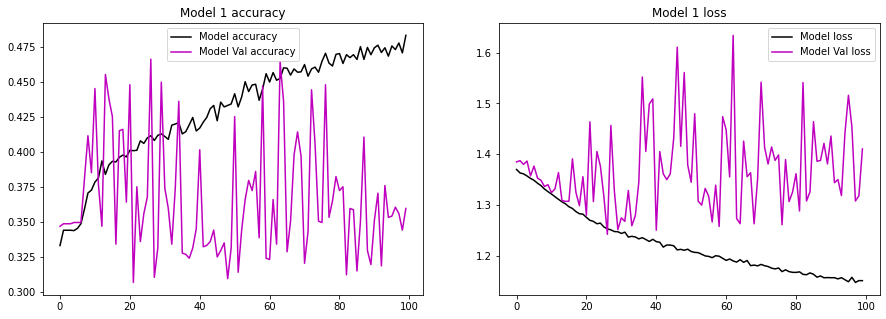

In [22]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [23]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [24]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.12991 and Training Accuracy 50.47%
Validation Loss 1.41036 and Validation Accuracy 35.97%


In [25]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")

pred = np.argmax(model.predict(xtrain_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(pred, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       1.00      1.00      1.00      1424
         exc       0.45      1.00      0.62      1096
         neu       0.00      0.00      0.00       607
         sad       0.00      0.00      0.00       711

    accuracy                           0.66      3838
   macro avg       0.36      0.50      0.41      3838
weighted avg       0.50      0.66      0.55      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# CR untuk Validation Data
print("model 1")
pred = np.argmax(model.predict(xtest_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.51      0.20      0.28       384
         exc       0.16      0.91      0.28       170
         neu       0.00      0.00      0.00       299
         sad       0.00      0.00      0.00       245

    accuracy                           0.21      1098
   macro avg       0.17      0.28      0.14      1098
weighted avg       0.20      0.21      0.14      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.2  0.68 0.12 0.  ]
 [0.09 0.75 0.16 0.  ]
 [0.13 0.23 0.64 0.  ]
 [0.08 0.75 0.17 0.  ]]


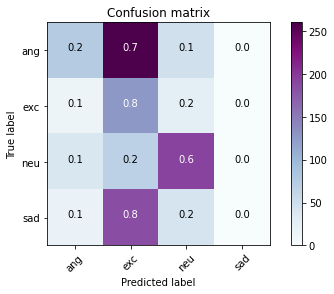

In [29]:
import itertools
y_pred = np.argmax(model.predict(xtest_mocap_combined), axis=1)
y_pred_classes = np.argmax(y_pred) 
# y_true = np.argmax(ytest_mocap_combined,axis=1) 

from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(ytest_mocap_combined, y_pred)
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 



# **Model_Head 1C**

In [16]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_3():
    img_inputs = keras.Input(shape=(200, 189, 1))
    conv_1 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 64))(conv_3)
    
    #LSTM
    x = LSTM(64, return_sequences=True)(x)
    x = SeqSelfAttention(attention_activation ='tanh')(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [17]:
model = create_model_3()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 189, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 189, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 94, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 94, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 47, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 47, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 47, 64)        36928 

In [18]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='wav2vec_Mocap_com1CcccC', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 1e-5,
                         "epochs": 100,
                         "batch_size": 100,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "2D-CNN_LSTM-Att",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

In [19]:
optimizer=keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer, config.loss_fn, 
              config.metrics)

In [20]:
hist = model.fit(xtrain_mocap_combined, ytrain_mocap_combined, 
                 batch_size=config.batch_size, epochs=config.epochs, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_combined, ytest_mocap_combined), callbacks=[WandbCallback()])

# validation_data=(xtest_mocap_combined, ytest_mocap_combined)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/100
39/39 [==============================] - 27s 528ms/step - loss: 3.0210 - acc: 0.2782 - val_loss: 1.3325 - val_acc: 0.3670
Epoch 2/100
39/39 [==============================] - 14s 369ms/step - loss: 1.3198 - acc: 0.3694 - val_loss: 1.3858 - val_acc: 0.3424
Epoch 3/100
39/39 [==============================] - 14s 371ms/step - loss: 1.2530 - acc: 0.4198 - val_loss: 1.3561 - val_acc: 0.3270
Epoch 4/100
39/39 [==============================] - 14s 373ms/step - loss: 1.2491 - acc: 0.4131 - val_loss: 1.3725 - val_acc: 0.3543
Epoch 5/100
39/39 [==============================] - 15s 374ms/step - loss: 1.2007 - acc: 0.4434 - val_loss: 1.4886 - val_acc: 0.3534
Epoch 6/100
39/39 [==============================] - 15s 377ms/step - loss: 1.1578 - acc: 0.4861 - val_loss: 1.4024 - val_acc: 0.3689
Epoch 7/100
39/39 [==============================] - 15s 378ms/step - loss: 1.1818 - acc: 0.4584 - val_loss

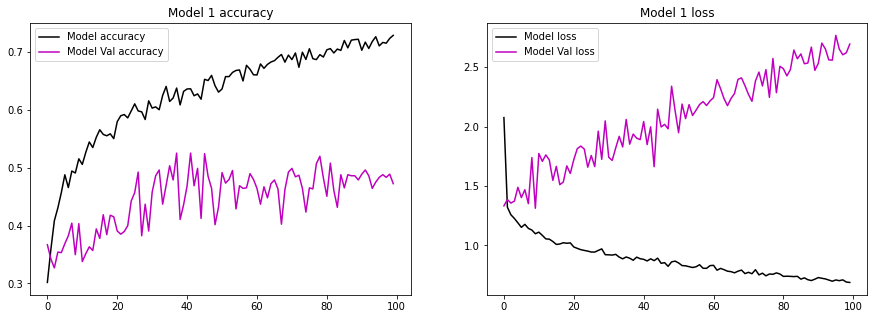

In [21]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [22]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [23]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.68759 and Training Accuracy 74.28%
Validation Loss 2.69491 and Validation Accuracy 47.27%


In [24]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")

pred = np.argmax(model.predict(xtrain_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(pred, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       1.00      1.00      1.00      1128
         exc       0.36      1.00      0.53       974
         neu       0.00      0.00      0.00       923
         sad       0.00      0.00      0.00       813

    accuracy                           0.55      3838
   macro avg       0.34      0.50      0.38      3838
weighted avg       0.39      0.55      0.43      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# CR untuk Validation Data
print("model 1")
pred = np.argmax(model.predict(xtest_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.45      0.61      0.52       384
         exc       0.20      0.69      0.31       170
         neu       0.00      0.00      0.00       299
         sad       0.00      0.00      0.00       245

    accuracy                           0.32      1098
   macro avg       0.16      0.33      0.21      1098
weighted avg       0.19      0.32      0.23      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.61 0.27 0.12 0.  ]
 [0.31 0.46 0.24 0.  ]
 [0.27 0.03 0.69 0.  ]
 [0.6  0.24 0.16 0.  ]]


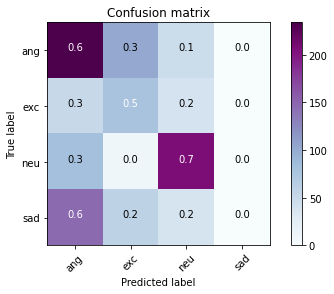

In [27]:
import itertools
y_pred = np.argmax(model.predict(xtest_mocap_combined), axis=1)
y_pred_classes = np.argmax(y_pred) 
# y_true = np.argmax(ytest_mocap_combined,axis=1) 

from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(ytest_mocap_combined, y_pred)
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 



In [28]:
def simple_conv3(optimizer='Adam'):
    model = Sequential()
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same', input_shape=(200, 189, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [29]:
model = simple_conv3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 95, 128)      1280      
_________________________________________________________________
dropout (Dropout)            (None, 100, 95, 128)      0         
_________________________________________________________________
activation (Activation)      (None, 100, 95, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 48, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 48, 128)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 50, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 24, 128)       1

In [32]:
#  "loss_function": "sparse_categorical_crossentropy(from_logits=True)",
#  "metrics": [keras.metrics.SparseCategoricalAccuracy(name="acc")]

# Initialize wandb with project
run = wandb.init(project ='wav2vec_Mocap_Adam_old', 
                 config={ #. include hyperparmeters and metadat
                         "learning_rate": 1e-5,
                         "epochs": 200,
                         "batch_size": 200,
                         "loss_fn": "sparse_categorical_crossentropy",
                         "architecture": "2D-CNN",
                         "dataset": "IEMOCAP",
                         "metrics":  ["acc"]                         
}) 

config = wandb.config  # We'll use this to configure our experiment

In [33]:
optimizer=keras.optimizers.Adam(config.learning_rate)
model.compile(optimizer, config.loss_fn, 
              config.metrics)

In [34]:
hist = model.fit(xtrain_mocap_combined, ytrain_mocap_combined, 
                 batch_size=config.batch_size, epochs=config.epochs, verbose=1, shuffle = True,
                 validation_data=(xtest_mocap_combined, ytest_mocap_combined), callbacks=[WandbCallback()])

# validation_data=(xtest_mocap_combined, ytest_mocap_combined)

Epoch 1/200
20/20 [==============================] - 14s 568ms/step - loss: 2.7837 - acc: 0.2505 - val_loss: 1.3901 - val_acc: 0.3479
Epoch 2/200
20/20 [==============================] - 8s 408ms/step - loss: 1.9980 - acc: 0.2739 - val_loss: 1.3848 - val_acc: 0.2914
Epoch 3/200
20/20 [==============================] - 8s 409ms/step - loss: 1.7941 - acc: 0.2653 - val_loss: 1.3701 - val_acc: 0.2769
Epoch 4/200
20/20 [==============================] - 8s 411ms/step - loss: 1.6387 - acc: 0.2755 - val_loss: 1.3789 - val_acc: 0.2814
Epoch 5/200
20/20 [==============================] - 8s 413ms/step - loss: 1.6065 - acc: 0.2691 - val_loss: 1.3805 - val_acc: 0.2778
Epoch 6/200
20/20 [==============================] - 8s 414ms/step - loss: 1.5164 - acc: 0.2914 - val_loss: 1.3753 - val_acc: 0.2668
Epoch 7/200
20/20 [==============================] - 8s 416ms/step - loss: 1.5121 - acc: 0.2835 - val_loss: 1.3706 - val_acc: 0.3315
Epoch 8/200
20/20 [==============================] - 8s 416ms/step -

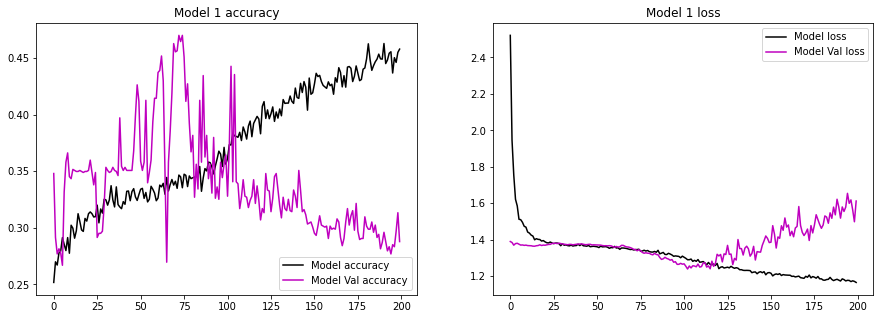

In [35]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [36]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [37]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.12946 and Training Accuracy 49.64%
Validation Loss 1.61229 and Validation Accuracy 28.78%


In [38]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")

pred = np.argmax(model.predict(xtrain_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(pred, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       1.00      1.00      1.00      1594
         exc       0.40      1.00      0.57       904
         neu       0.00      0.00      0.00       730
         sad       0.00      0.00      0.00       610

    accuracy                           0.65      3838
   macro avg       0.35      0.50      0.39      3838
weighted avg       0.51      0.65      0.55      3838



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# CR untuk Validation Data
print("model 1")
pred = np.argmax(model.predict(xtest_mocap_combined), axis=-1)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.62      0.05      0.10       384
         exc       0.16      0.99      0.27       170
         neu       0.00      0.00      0.00       299
         sad       0.00      0.00      0.00       245

    accuracy                           0.17      1098
   macro avg       0.19      0.26      0.09      1098
weighted avg       0.24      0.17      0.08      1098



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.05 0.3  0.64 0.01]
 [0.01 0.12 0.87 0.  ]
 [0.01 0.07 0.92 0.  ]
 [0.03 0.2  0.77 0.  ]]


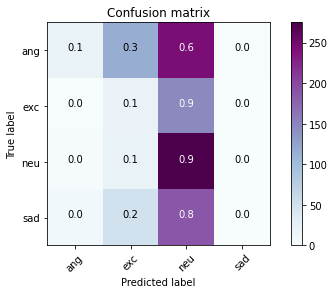

In [41]:
import itertools
y_pred = np.argmax(model.predict(xtest_mocap_combined), axis=1)
y_pred_classes = np.argmax(y_pred) 
# y_true = np.argmax(ytest_mocap_combined,axis=1) 

from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(ytest_mocap_combined, y_pred)
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 


In [ ]:
model = AttentionResNet()